# Dense Neural Network (NN) Exploration

In this notebook, we will lay out our approach for a Neural Network approach to predict a pose based on landmark. Additionally, we are storing out angle calculation and perspectively our angle error calculation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Neural Network

In [2]:
import tensorflow as tf


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, Sequential
from tensorflow.keras import models


In [15]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling1D, LeakyReLU
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.models import load_model
import joblib

In [5]:
from scipy.stats import uniform

In [6]:
# Load the datasets
train_df = pd.read_csv('train_landmark_all_raw.csv')
val_df = pd.read_csv('val_landmark_all_raw.csv')
test_df = pd.read_csv('test_landmark_all_raw.csv')

In [7]:
#train_df.head()


In [8]:
# Extract features (landmark coordinates) and labels
X_train = train_df.iloc[:, 1:52]  # Feature columns
y_train = train_df['y_main']  # Target variable


In [9]:
X_val = val_df.iloc[:, 1:52].values
y_val = val_df['y_main'].values


In [10]:
X_test = test_df.iloc[:, 1:52].values
y_test = test_df['y_main'].values


In [11]:
# Convert labels to numerical values
label_mapping = {label: idx for idx, label in enumerate(np.unique(y_train))}
y_train_numeric = np.array([label_mapping[label] for label in y_train])
y_val_numeric = np.array([label_mapping[label] for label in y_val])
y_test_numeric = np.array([label_mapping[label] for label in y_test])


In [12]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Saving the scaler
joblib.dump(scaler, 'scaler.pkl')

/Users/mirmachr/.pyenv/versions/3.10.6/envs/hathaproject/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/mirmachr/.pyenv/versions/3.10.6/envs/hathaproject/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


['scaler.pkl']

In [17]:
# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_numeric)
y_val_one_hot = to_categorical(y_val_numeric)
y_test_one_hot = to_categorical(y_test_numeric)

encoder = OneHotEncoder()

# Saving the encoder
joblib.dump(encoder, 'encoder.pkl')

['encoder.pkl']

In [18]:
# Build the neural network model
def initialize_model():
    model = models.Sequential()
    model.add(layers.Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
#     model.add(layers.Dense(64, activation='relu'))
#     model.add(layers.Dropout(0.5))
#     model.add(layers.Dense(32, activation='relu'))
#     model.add(layers.Dropout(0.5))
    model.add(layers.Dense(len(label_mapping), activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

model = initialize_model()


2023-11-24 10:40:53.266013: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-11-24 10:40:53.266417: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-11-24 10:40:53.266599: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-11-24 10:40:53.266940: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-24 10:40:53.267211: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [19]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy', patience=20)

# Start training
history = model.fit(X_train,
                    y_train_one_hot,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_val, y_val_one_hot),
                    callbacks=[es])

# # Train the model with validation data
# history = model.fit(X_train,
#                     y_train_one_hot,
#                     epochs=10,
#                     batch_size=32,
#                     validation_data=(X_val, y_val_one_hot))


Epoch 1/100
 1/17 [>.............................] - ETA: 6s - loss: 2.2490 - accuracy: 0.0938

2023-11-24 10:40:55.104674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-11-24 10:40:55.119503: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


17/17 [==============================] - 1s 20ms/step - loss: 1.6565 - accuracy: 0.3252 - val_loss: 1.0691 - val_accuracy: 0.6319
Epoch 2/100
17/17 [==============================] - 0s 18ms/step - loss: 1.1984 - accuracy: 0.5327 - val_loss: 0.8190 - val_accuracy: 0.6944
Epoch 3/100
17/17 [==============================] - 0s 10ms/step - loss: 0.9925 - accuracy: 0.6243 - val_loss: 0.6576 - val_accuracy: 0.8264
Epoch 4/100
17/17 [==============================] - 0s 10ms/step - loss: 0.7883 - accuracy: 0.6935 - val_loss: 0.5381 - val_accuracy: 0.8681
Epoch 5/100
17/17 [==============================] - 0s 10ms/step - loss: 0.7109 - accuracy: 0.7495 - val_loss: 0.4558 - val_accuracy: 0.8958
Epoch 6/100
17/17 [==============================] - 0s 11ms/step - loss: 0.6307 - accuracy: 0.7645 - val_loss: 0.4086 - val_accuracy: 0.9306
Epoch 7/100
17/17 [==============================] - 0s 10ms/step - loss: 0.5599 - accuracy: 0.7869 - val_loss: 0.3538 - val_accuracy: 0.9236
Epoch 8/100
17/17 

17/17 [==============================] - 0s 10ms/step - loss: 0.0434 - accuracy: 0.9869 - val_loss: 0.0566 - val_accuracy: 0.9792
Epoch 59/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0315 - accuracy: 0.9981 - val_loss: 0.0558 - val_accuracy: 0.9792
Epoch 60/100
17/17 [==============================] - 0s 10ms/step - loss: 0.0375 - accuracy: 0.9869 - val_loss: 0.0497 - val_accuracy: 0.9792
Epoch 61/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0347 - accuracy: 0.9888 - val_loss: 0.0397 - val_accuracy: 0.9722
Epoch 62/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0420 - accuracy: 0.9869 - val_loss: 0.0382 - val_accuracy: 0.9792
Epoch 63/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0354 - accuracy: 0.9888 - val_loss: 0.0401 - val_accuracy: 0.9861
Epoch 64/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0320 - accuracy: 0.9907 - val_loss: 0.0514 - val_accuracy: 0.9792
Epoch 65/100
17/1

In [20]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               6656      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 15237 (59.52 KB)
Trainable params: 15237 (59.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


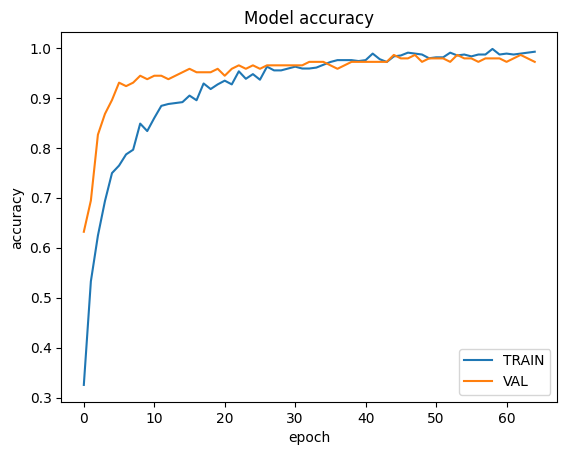

In [21]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()


In [22]:
# # Train the model with validation data
# history = model.fit(X_train,
#                     y_train_one_hot,
#                     epochs=10,
#                     batch_size=32,
#                     validation_data=(X_val, y_val_one_hot))

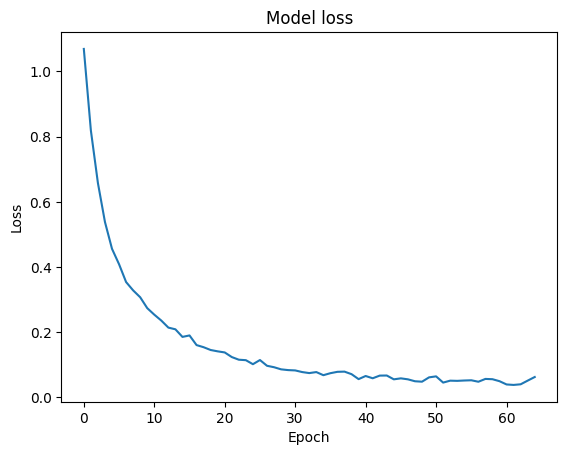

In [23]:
def plot_history(history):
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

plot_history(history)


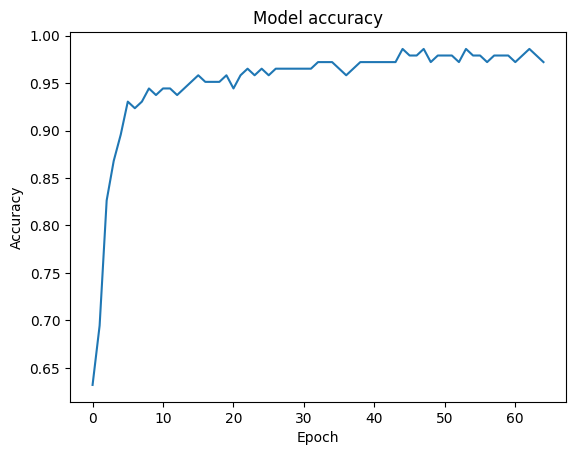

In [24]:
def plot_history_accuracy(history):
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

plot_history_accuracy(history)


In [25]:
# Convert test labels to one-hot encoding
y_test_one_hot = to_categorical(y_test_numeric)

# Evaluate the model on the test set
results = model.evaluate(X_test, y_test_one_hot, verbose=0)


In [26]:
print(f'Test Accuracy: {results[1]*100:.2f}%')
print(f'Test Loss: {results[0]}')


Test Accuracy: 92.86%
Test Loss: 0.11015759408473969


In [27]:
X_pred = X_test[0].reshape(1,-1)


In [28]:
%time
prediction = model.predict(X_pred)


CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 21 µs
1/1 [==============================] - 0s 81ms/step


In [29]:
predict_class = np.argmax(prediction, axis = 1)
predict_class


array([0])

In [30]:
predicted_labels = np.argmax(prediction, axis=1)


In [31]:
predicted_class_names = [class_name for class_name, idx in label_mapping.items() if idx in predict_class]
predicted_class_names[0]


'downdog'

In [32]:
# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#   """Plots the confusion matrix."""
#   if normalize:
#     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print("Normalized confusion matrix")
#   else:
#     print('Confusion matrix, without normalization')

#   plt.imshow(cm, interpolation='nearest', cmap=cmap)
#   plt.title(title)
#   plt.colorbar()
#   tick_marks = np.arange(len(classes))
#   plt.xticks(tick_marks, classes, rotation=55)
#   plt.yticks(tick_marks, classes)
#   fmt = '.2f' if normalize else 'd'
#   thresh = cm.max() / 2.
#   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#     plt.text(j, i, format(cm[i, j], fmt),
#               horizontalalignment="center",
#               color="white" if cm[i, j] > thresh else "black")

#   plt.ylabel('True label')
#   plt.xlabel('Predicted label')
#   plt.tight_layout()

# # Classify pose in the TEST dataset using the trained model
# y_pred = model.predict(X_test)

# # Convert the prediction result to class name
# y_pred_label = [predict_class[i] for i in np.argmax(y_pred, axis=1)]
# y_true_label = [predict_class[i] for i in np.argmax(y_test, axis=1)]

# # Plot the confusion matrix
# cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
# plot_confusion_matrix(cm,
#                       class_names,
#                       title ='Confusion Matrix of Pose Classification Model')

# # Print the classification report
# print('\nClassification Report:\n', classification_report(y_true_label,
#                                                           y_pred_label))


In [29]:
model.save('amazing_model.keras')  # Save the entire model


## Masaki

In [30]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2
import os
import pandas as pd

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display


In [31]:
# Model Initialization
model_name = "movenet_lightning"
module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
input_size = 192
model = module.signatures['serving_default']


In [32]:
# Choose image file and preprocess

image_path = "../clean/00000320.jpg"
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)

# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)


2023-11-23 17:36:59.496676: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: ../clean/00000320.jpg; No such file or directory


NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} ../clean/00000320.jpg; No such file or directory [Op:ReadFile]

In [ ]:
# Detect landmarks on image
model = module.signatures["serving_default"]
input_image = tf.cast(input_image, dtype=tf.int32)
input_image = input_image[..., :3]
outputs = model(input_image)

# 1D array of xyz coordinates. X1, Y1, Z1, X2, ... , Yn, Zn format
xyz = outputs["output_0"].numpy().reshape(51).tolist()


In [ ]:
# Helper method for drawing landmarks
def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot


In [ ]:
# Get list of image file names in given directory
dir_path_train_dd = "../clean"
file_names = []
for entry in os.listdir(dir_path_train_dd):
    file_names.append(entry)


In [ ]:
# Create DF of xyz values
df = []

for file in file_names:
    dir_path_train_dd = f"../clean/{file}"
    if not file.endswith((".jpg", ".png")):
        pass
    else:
        print(dir_path_train_dd)
        image = tf.io.read_file(dir_path_train_dd)
        image = tf.image.decode_jpeg(image)
        input_image = tf.expand_dims(image, axis=0)
        input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
        input_image = input_image[..., :3]

        model = module.signatures["serving_default"]
        input_image = tf.cast(input_image, dtype=tf.int32)
        outputs = model(input_image)
        df.append(outputs["output_0"].numpy().reshape(51).tolist())


In [ ]:
data = pd.DataFrame(df)


In [ ]:
data["label"] = "downdog"


In [ ]:
data.head()


In [ ]:
# Create DF of xyz values
df = []
xyz = []
for file in file_names:
    dir_path_train_dd = f"../clean/{file}"
    if not file.endswith((".jpg", ".png")):
        pass
    else:
        print(dir_path_train_dd)
        image = tf.io.read_file(dir_path_train_dd)
        image = tf.image.decode_jpeg(image)
        input_image = tf.expand_dims(image, axis=0)
        input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
        input_image = input_image[..., :3]

        model = module.signatures["serving_default"]
        input_image = tf.cast(input_image, dtype=tf.int32)
        outputs = model(input_image)
        df.append(outputs["output_0"].numpy().reshape(51).tolist())
        xyz.append(outputs["output_0"].numpy()[0][0])


In [ ]:
xyz[0]


In [ ]:
xyz[8]


## Angle Calculator

In [ ]:
image_landmarks = xyz[6]


In [ ]:
lm = image_landmarks
lm


In [ ]:
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}


In [ ]:
# landmark_dict = {
#     'landmarks_left_elbow' : (lm[5], lm[7], lm[9]),
#     'landmarks_right_elbow' : (lm[6], lm[8], lm[10]),
#     'landmarks_left_shoulder' : (lm[7], lm[9], lm[11]),
#     'landmarks_right_shoulder' : (lm[8], lm[10], lm[12]),
#     'landmarks_hip_left' : (lm[5], lm[11], lm[13]),
#     'landmarks_hip_right' : (lm[6], lm[12], lm[14]),
#     'landmarks_left_knee' : (lm[11], lm[13], lm[15]),
#     'landmarks_right_knee' : (lm[12], lm[14], lm[16])
#         }


In [ ]:
def angle_function(lm):

    landmark_dict = {
    'landmarks_left_elbow' : (lm[5], lm[7], lm[9]),
    'landmarks_right_elbow' : (lm[6], lm[8], lm[10]),
    'landmarks_left_shoulder' : (lm[7], lm[9], lm[11]),
    'landmarks_right_shoulder' : (lm[8], lm[10], lm[12]),
    'landmarks_hip_left' : (lm[5], lm[11], lm[13]),
    'landmarks_hip_right' : (lm[6], lm[12], lm[14]),
    'landmarks_left_knee' : (lm[11], lm[13], lm[15]),
    'landmarks_right_knee' : (lm[12], lm[14], lm[16])
        }

    def angle_calculator(landmarks):

        # Converting the points into numpy arrays
        p1 = np.array(landmarks[0])
        p2 = np.array(landmarks[1])
        p3 = np.array(landmarks[2])

        # Creating the Vectors between two points
        vec_p1 = p1-p2
        vec_p2 = p3-p2

        # Calculating the cosine of the angle
        cosine_angle = np.dot(vec_p1,vec_p2) / (np.linalg.norm(vec_p1)*np.linalg.norm(vec_p2))

        # Calculating angle
        angle = np.arccos(cosine_angle)

        # Calculating degrees
        angle_degrees = np.degrees(angle)

        return angle_degrees

    angle_name_list = ['angle_elbow_left',
                   'angle_elbow_right',
                   'angle_shoulder_left',
                   'angle_shoulder_right',
                   'angle_hip_left',
                   'angle_hip_right',
                   'angle_knee_left',
                   'angle_knee_right',
                  ]

    angle_dict = {}

    for dictkey, listkey in zip(landmark_dict, angle_name_list):
        i = angle_calculator(landmark_dict[dictkey])
        angle_dict[listkey] = i

    angle_list = [angle_dict[key] for key in angle_dict]

    return angle_dict, angle_list


In [ ]:
angle_left_elbow = angle_calculator(landmark_dict['landmarks_left_elbow'])
angle_left_elbow


In [ ]:
angle_dict = angle_function(lm)[0]


In [ ]:
angle_list = angle_function(lm)[1]


In [ ]:
# angle_name_list = ['angle_elbow_left',
#                    'angle_elbow_right',
#                    'angle_shoulder_left',
#                    'angle_shoulder_right',
#                    'angle_hip_left',
#                    'angle_hip_right',
#                    'angle_knee_left',
#                    'angle_knee_right',
#                   ]


In [ ]:
# angle_dict = {}


In [ ]:
# for dictkey, listkey in zip(landmark_dict, angle_name_list):
#     i = angle_calculator(landmark_dict[dictkey])
#     angle_dict[listkey] = i


In [ ]:
angle_dict


These are the angles we need!

In [ ]:
# angle_list = [angle_dict[key] for key in angle_dict]


In [ ]:
angle_list


In [ ]:
xyz


In [ ]:
lst = []
lst


## Angle Comparison Tool

In [ ]:
lst = []
for x in xyz:
    lst.append(angle_function(x)[1])


In [ ]:
lst


In [ ]:
array = np.asarray(lst)


In [ ]:
df = pd.DataFrame(lst)


In [ ]:
angle_name_list = ['angle_elbow_left',
                   'angle_elbow_right',
                   'angle_shoulder_left',
                   'angle_shoulder_right',
                   'angle_hip_left',
                   'angle_hip_right',
                   'angle_knee_left',
                   'angle_knee_right',
                  ]


In [ ]:
df.columns = angle_name_list


In [ ]:
df


## Angle Error